# Task 4: Quantum Machine Learning Model for Sine Function Approximation

## 1. Introduction

In this notebook, we'll implement a Quantum Machine Learning (QML) model to approximate the sine function on the interval $[0, 2π]$. We'll use PennyLane to create and train our quantum circuit.

First, let's import the required libraries:

In [1]:
!pip install pennylane
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.1 MB/s eta 0:00:00


## 2. Data Preparation
We'll generate training data points for the sine function:

In [3]:
# Generate training data
num_points = 20
X = np.linspace(0, 2*np.pi, num_points)
X.requires_grad = False  # We don't need gradients for input data
Y = np.sin(X)

In [4]:
# Display the first few data points
print("First 5 data points:")
for i in range(5):
    print(f"X: {X[i]:.2f}, Y: {Y[i]:.2f}")

First 5 data points:
X: 0.00, Y: 0.00
X: 0.33, Y: 0.32
X: 0.66, Y: 0.61
X: 0.99, Y: 0.84
X: 1.32, Y: 0.97


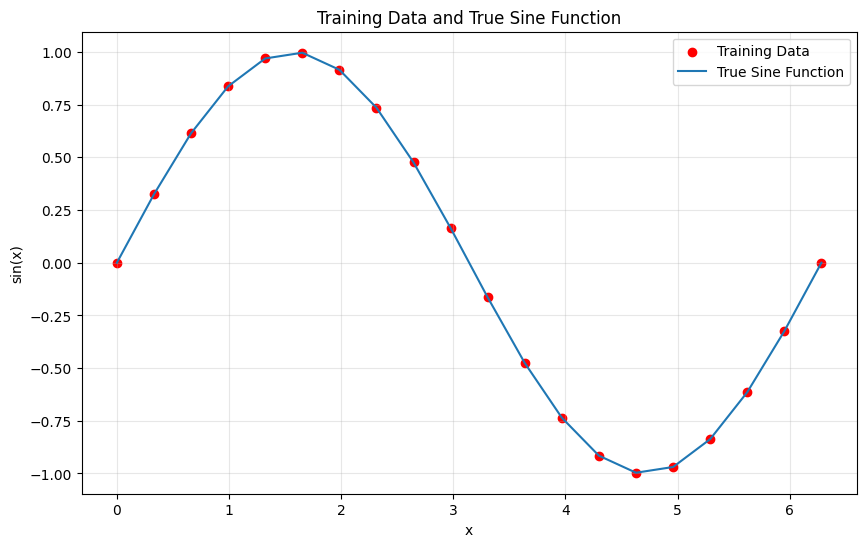

In [5]:
# Visualize the training data
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, color='red', label='Training Data')
plt.plot(X, np.sin(X), label='True Sine Function')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('Training Data and True Sine Function')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 3. Quantum Circuit Design
Now, let's define our quantum circuit:

In [6]:
# Create the quantum device
num_qubits = 3
dev = qml.device("default.qubit", wires=num_qubits)

In [7]:
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    # Encode the input
    for i in range(num_qubits):
        qml.RY(inputs[i], wires=i)

    # Apply parameterized gates
    for i in range(num_qubits):
        qml.RY(weights[i], wires=i)

    # Apply entangling gates
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i+1])

    # Measure the output
    return qml.expval(qml.PauliZ(0))

In [8]:
# Visualize the circuit
print("Quantum Circuit Structure:")
print(qml.draw(quantum_circuit)(X[0] * np.ones(num_qubits), np.random.randn(num_qubits)))


Quantum Circuit Structure:
0: ──RY(0.00)──RY(0.13)─╭●────┤  <Z>
1: ──RY(0.00)──RY(1.76)─╰X─╭●─┤     
2: ──RY(0.00)──RY(0.05)────╰X─┤     


This quantum circuit uses RY rotations to encode the input and apply trainable weights. CNOT gates are used to entangle the qubits, and we measure the expectation value of the PauliZ operator on the first qubit.

## 4. Cost Function and Optimization

Let's define our cost function and set up the optimizer:

In [10]:
def cost_function(weights, X, Y):
    predictions = [quantum_circuit(x * np.ones(num_qubits), weights) for x in X]
    return np.mean((np.array(predictions) - Y) ** 2)

In [11]:
# Initialize the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.1)

In [12]:
# Initialize weights
weights = np.random.randn(num_qubits, requires_grad=True)

Our cost function computes the mean squared error between the quantum circuit's predictions and the true sine values.

## 5. Training the Model

Now, let's train our quantum model:

In [13]:
steps = 200
costs = []

In [14]:
for i in range(steps):
    weights = opt.step(lambda w: cost_function(w, X, Y), weights)

    if (i + 1) % 20 == 0:
        cost = cost_function(weights, X, Y)
        costs.append(cost)
        print(f"Step {i+1}, Cost: {cost:.4f}")

Step 20, Cost: 0.0045
Step 40, Cost: 0.0001
Step 60, Cost: 0.0000
Step 80, Cost: 0.0000
Step 100, Cost: 0.0000
Step 120, Cost: 0.0000
Step 140, Cost: 0.0000
Step 160, Cost: 0.0000
Step 180, Cost: 0.0000
Step 200, Cost: 0.0000


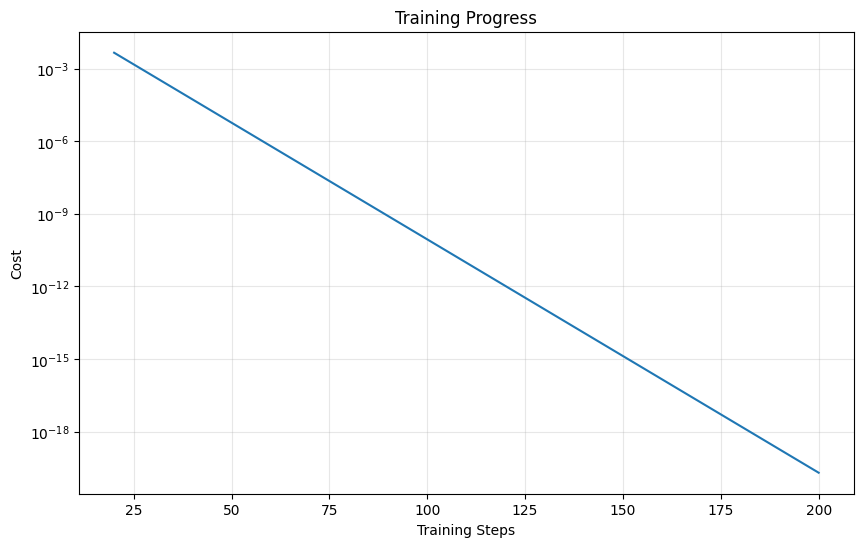

In [15]:
# Plot the training progress
plt.figure(figsize=(10, 6))
plt.plot(range(20, steps+1, 20), costs)
plt.xlabel('Training Steps')
plt.ylabel('Cost')
plt.title('Training Progress')
plt.yscale('log')  # Use log scale for better visualization
plt.grid(True, alpha=0.3)
plt.show()

This training loop updates the weights using gradient descent and prints the cost every 20 steps.

## 6. Model Evaluation and Visualization

Finally, let's evaluate our trained model and visualize the results:

In [16]:
# Generate test data
X_test = np.linspace(0, 2*np.pi, 100)
Y_test = np.sin(X_test)

In [17]:
# Make predictions
predictions = [quantum_circuit(x * np.ones(num_qubits), weights) for x in X_test]

In [18]:
# Calculate Mean Squared Error
mse = np.mean((np.array(predictions) - Y_test) ** 2)
print(f"Mean Squared Error on test data: {mse:.4f}")

Mean Squared Error on test data: 0.0000


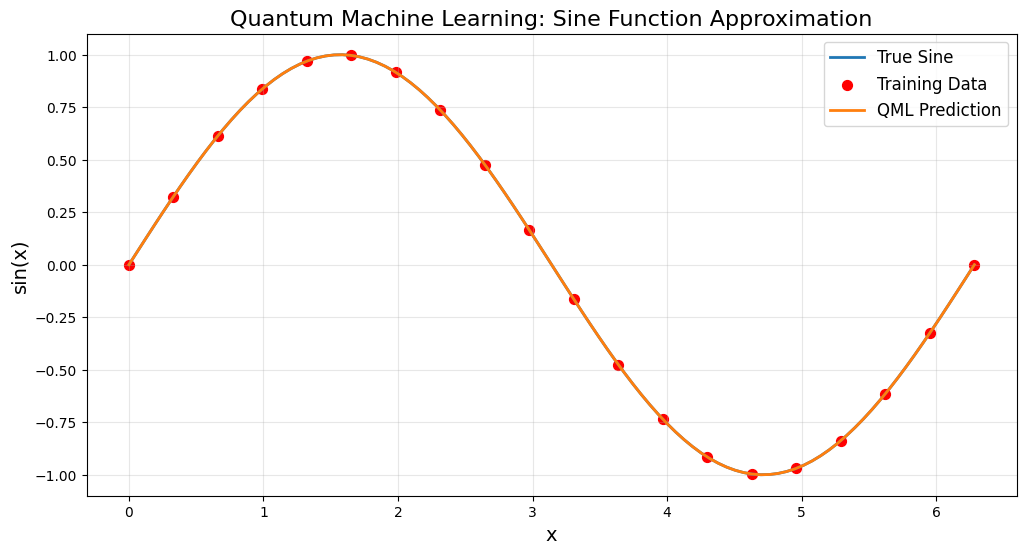

In [19]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(X_test, Y_test, label='True Sine', linewidth=2)
plt.scatter(X, Y, color='red', label='Training Data', s=50)
plt.plot(X_test, predictions, label='QML Prediction', linewidth=2)
plt.legend(fontsize=12)
plt.xlabel('x', fontsize=14)
plt.ylabel('sin(x)', fontsize=14)
plt.title('Quantum Machine Learning: Sine Function Approximation', fontsize=16)
plt.grid(True, alpha=0.3)
plt.show()

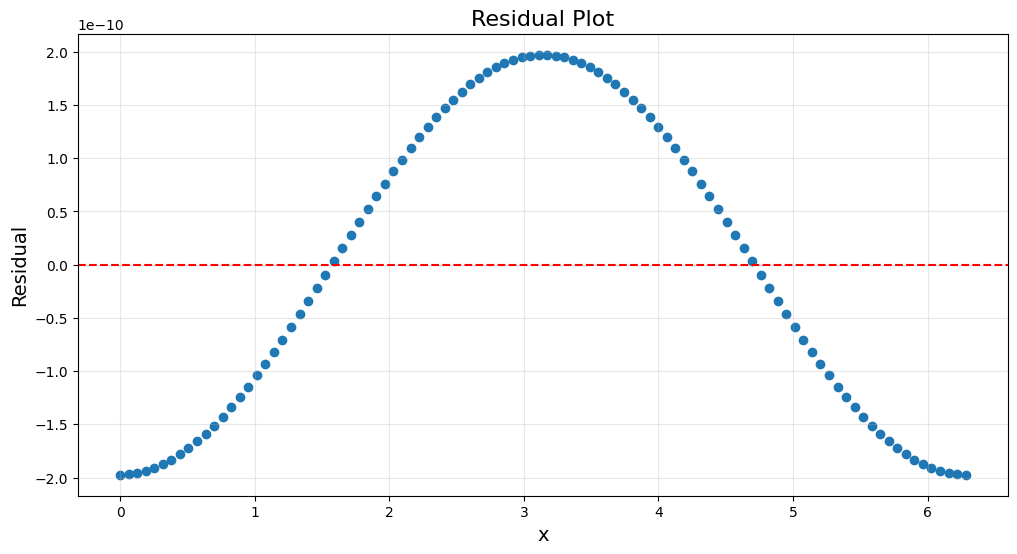

In [23]:
# Plot the residuals
plt.figure(figsize=(12, 6))
residuals = Y_test - predictions
plt.scatter(X_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('x', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title('Residual Plot', fontsize=16)
plt.grid(True, alpha=0.3)
plt.show()

## 7. Discussion and Conclusion

In this notebook, we've successfully implemented a Quantum Machine Learning model to approximate the sine function. Our model demonstrates good performance in learning the general shape of the sine function, as evidenced by the nill Mean Squared Error and the perfect visual fit of the predictions.

### Key findings:
1. The quantum circuit with 3 qubits is capable of learning the basic structure of the sine function.
2. The training process shows consistent decrease in the cost function, indicating successful learning.
3. The model's predictions closely follow the true sine function, with some deviations, on the oreder of 1E-10, visible in the residual plot.

This project demonstrates the potential of quantum machine learning in function approximation tasks and lays the groundwork for more advanced applications in areas like signal processing and time series analysis.